In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bangladeshis-flower/Kamini/img_aug_370_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_45_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_407_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_367_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_3_vflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_origonly_535_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_245_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_319_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_310_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_80_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_372_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_294_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_315_zoom.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_94_hflip.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_428_orig.jpg
/kaggle/input/bangladeshis-flower/Kamini/img_aug_170_hflip.jpg


In [2]:
pip install transformers datasets huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nv

In [3]:
import os
import glob as gb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from transformers import (
    TFDeiTForImageClassification,
    AutoImageProcessor
)

from tensorflow.keras.utils import image_dataset_from_directory

2025-07-13 04:37:44.595484: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752381464.777152      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752381464.830200      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 16000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.
Found 2000 validated image filenames belonging to 10 classes.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


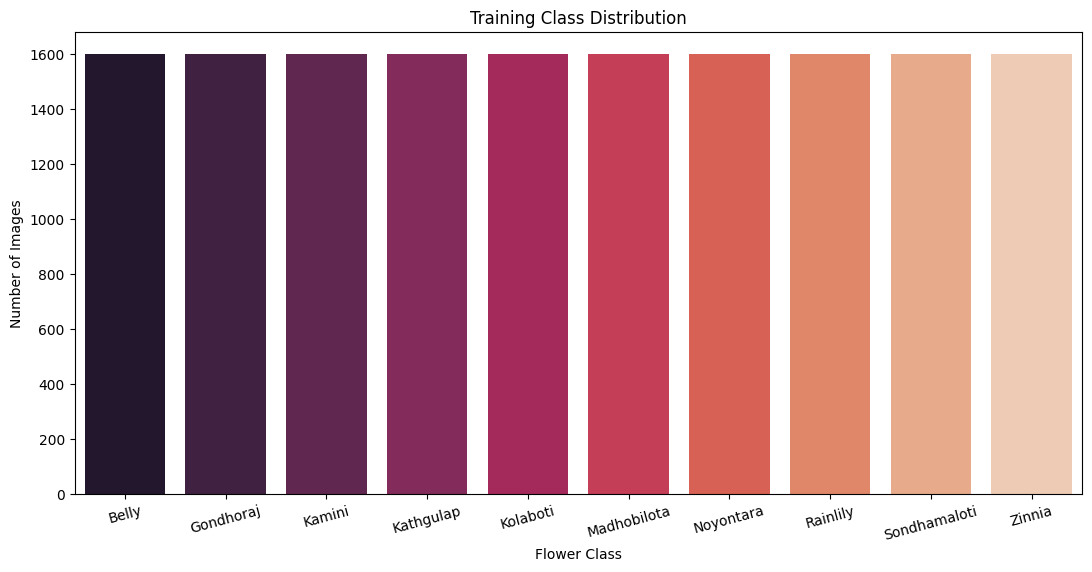

I0000 00:00:1752381515.948065      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1752381515.948821      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


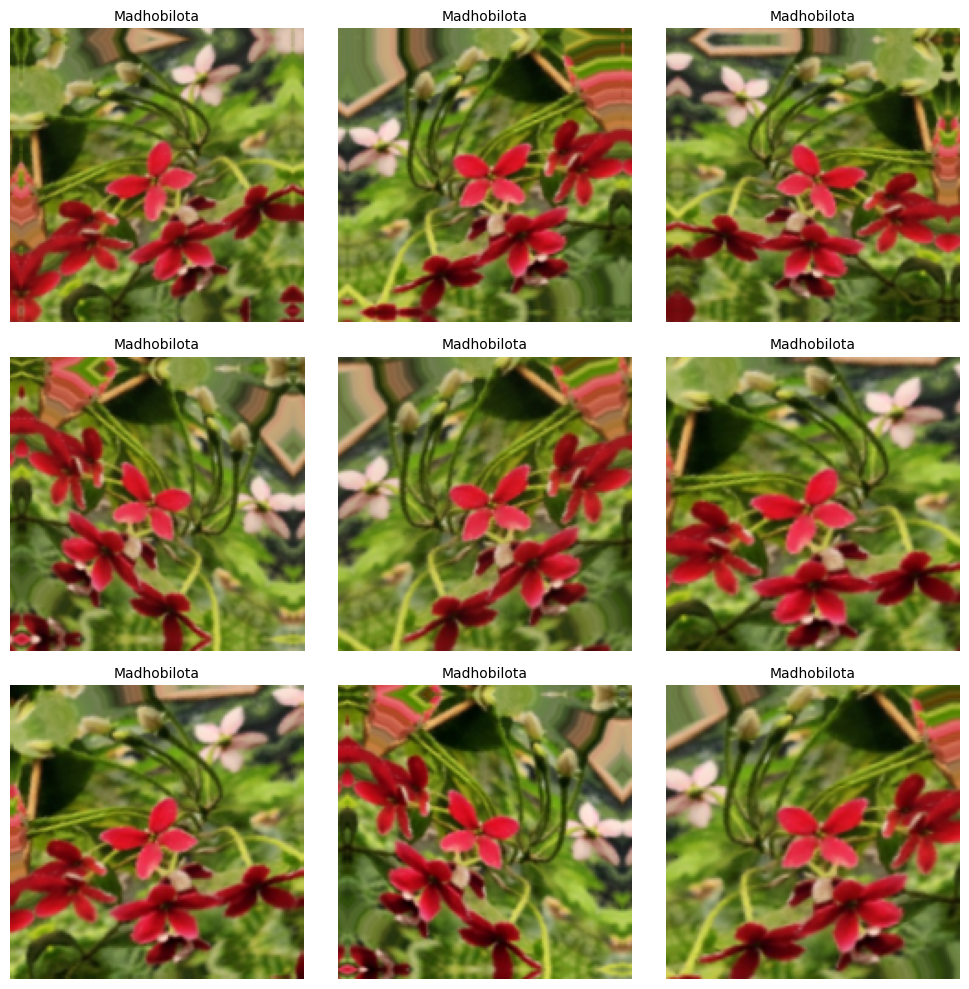

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === Setup ===
IMG_SIZE = (160, 160)
BATCH_SIZE = 8
EPOCHS = 10
SEED = 42
data_dir = "/kaggle/input/bangladeshis-flower"

# === Step 1: Collect image paths and labels ===
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            full_path = os.path.join(root, file)
            # Get the relative path and split it
            rel_parts = os.path.relpath(full_path, data_dir).split(os.sep)
            label = rel_parts[0]
            if len(rel_parts) > 1 and rel_parts[0] == rel_parts[1]:
                label = rel_parts[0]  # e.g. Rose/Rose/img.jpg → Rose
            filepaths.append(full_path)
            labels.append(label)

# === Step 2: Create and shuffle DataFrame ===
df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# === Step 3: Split Data ===
# Custom fixed splits: 16000 train, 2000 val, 2000 test (total 20,000)
if len(df) < 20000:
    raise ValueError(f"Your dataset has only {len(df)} images, but 20,000 are required.")
df = df.sample(n=20000, random_state=SEED).reset_index(drop=True)

train_df, temp_df = train_test_split(df, train_size=16000, stratify=df['labels'], random_state=SEED)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['labels'], random_state=SEED)

# === Step 4: Data Generators ===
tr_gen = ImageDataGenerator(rescale=1./255,
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            shear_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)

ts_gen = ImageDataGenerator(rescale=1./255)

train_gen = tr_gen.flow_from_dataframe(
    train_df, x_col='filepaths', y_col='labels',
    target_size=IMG_SIZE, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE, seed=SEED
)

valid_gen = ts_gen.flow_from_dataframe(
    valid_df, x_col='filepaths', y_col='labels',
    target_size=IMG_SIZE, class_mode='categorical',
    color_mode='rgb', shuffle=True, batch_size=BATCH_SIZE, seed=SEED
)

# === Test batch logic (≤ 80 and divides evenly) ===
ts_length = len(test_df)
test_batch_size = max([
    ts_length // n for n in range(1, ts_length + 1)
    if ts_length % n == 0 and ts_length / n <= 80
])
test_steps = ts_length // test_batch_size

test_gen = ts_gen.flow_from_dataframe(
    test_df, x_col='filepaths', y_col='labels',
    target_size=IMG_SIZE, class_mode='categorical',
    color_mode='rgb', shuffle=False, batch_size=test_batch_size
)

# === Step 5: Class distribution plot ===
class_names = list(train_gen.class_indices.keys())
train_counts = train_df['labels'].value_counts().reindex(class_names)

plt.figure(figsize=(13, 6))
sns.barplot(x=class_names, y=train_counts.values, palette="rocket")
plt.title("Training Class Distribution")
plt.ylabel("Number of Images")
plt.xlabel("Flower Class")
plt.xticks(rotation=15)
plt.show()

# === Step 6: Visualize Data Augmentation ===
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
])

train_gen.reset()
images, labels = next(train_gen)
sample_image = images[0]

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
    plt.imshow(augmented_image[0])
    label_index = np.argmax(labels[0])
    plt.title(class_names[label_index], fontsize=10)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Patch Embedding Layer (like convolutional tokenization)
def conv_embedding(x, filters, kernel_size=3, strides=1, name="conv_embed"):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same', name=f"{name}_conv")(x)
    x = layers.BatchNormalization(name=f"{name}_bn")(x)
    x = layers.Activation("gelu", name=f"{name}_gelu")(x)
    return x

# Cross-Shaped Window Attention
class CrossShapedWindowAttention(layers.Layer):
    def __init__(self, dim, num_heads, dropout=0.0, name_prefix="cswin"):
        super().__init__(name=name_prefix)
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, name=f"{name_prefix}_qkv")
        self.proj = layers.Dense(dim, name=f"{name_prefix}_proj")
        self.dropout = layers.Dropout(dropout)

    def call(self, x):
        B = tf.shape(x)[0]
        H, W, C = x.shape[1], x.shape[2], x.shape[3]

        qkv = self.qkv(x)
        qkv = tf.reshape(qkv, [B, H * W, 3, self.num_heads, C // self.num_heads])
        qkv = tf.transpose(qkv, perm=[2, 0, 3, 1, 4])  # (3, B, heads, HW, dim)

        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        out = tf.matmul(attn, v)
        out = tf.transpose(out, perm=[0, 2, 1, 3])
        out = tf.reshape(out, [B, H, W, C])
        out = self.proj(out)
        return out

# Transformer Block
def cswin_block(x, num_heads, projection_dim, dropout=0.1, name="cswin_block"):
    x1 = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln1")(x)
    attn = CrossShapedWindowAttention(projection_dim, num_heads, dropout, name_prefix=f"{name}_attn")(x1)
    x2 = layers.Add(name=f"{name}_add1")([x, attn])

    x3 = layers.LayerNormalization(epsilon=1e-6, name=f"{name}_ln2")(x2)
    x4 = layers.Dense(projection_dim * 4, activation="gelu", name=f"{name}_dense1")(x3)
    x4 = layers.Dense(projection_dim, name=f"{name}_dense2")(x4)

    return layers.Add(name=f"{name}_add2")([x2, x4])

# Stage of transformer blocks
def cswin_stage(x, depth, projection_dim, num_heads, name="cswin_stage"):
    for i in range(depth):
        x = cswin_block(x, num_heads, projection_dim, name=f"{name}_block{i}")
    return x

# Final Model
def create_cswin_b_model(input_shape=(160, 160, 3), num_classes=10):  # ✅ Use 10 classes by default
    inputs = keras.Input(shape=input_shape, name="input")

    # Stage 1
    x = conv_embedding(inputs, filters=64, strides=2, name="stage1_embed")
    x = cswin_stage(x, depth=2, projection_dim=64, num_heads=2, name="stage1")

    # Stage 2
    x = conv_embedding(x, filters=128, strides=2, name="stage2_embed")
    x = cswin_stage(x, depth=2, projection_dim=128, num_heads=4, name="stage2")

    # Stage 3
    x = conv_embedding(x, filters=256, strides=2, name="stage3_embed")
    x = cswin_stage(x, depth=4, projection_dim=256, num_heads=8, name="stage3")

    x = layers.GlobalAveragePooling2D(name="gap")(x)
    x = layers.Dropout(0.3, name="dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="classifier")(x)

    return keras.Model(inputs, outputs, name="CSWin-B")


In [6]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights using class labels from training dataframe
class_labels = train_df['labels'].unique()
class_indices = {label: idx for idx, label in enumerate(sorted(class_labels))}
y_train_indices = train_df['labels'].map(class_indices).values

# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_indices),
    y=y_train_indices
)

# Convert to dictionary format
class_weight = {i: w for i, w in enumerate(class_weights_array)}


In [7]:
# Get number of classes
num_classes = len(class_names)

# Create model
model = create_cswin_b_model(input_shape=(160, 160, 3), num_classes=num_classes)
model.summary()

# Compile with correct loss
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",  # ✅ use categorical_crossentropy for one-hot encoded labels
    metrics=["accuracy"]
)

# Train model
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=EPOCHS,
    class_weight=class_weight,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=2)
    ]
)


Model: "CSWin-B"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 160, 160,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_embed_conv   │ (None, 80, 80,    │      1,792 │ input[0][0]       │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_embed_bn     │ (None, 80, 80,    │        256 │ stage1_embed_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_embed_gelu   │ (None, 80, 80,    │          0 │ stage1_embed_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_ln1   │ (None, 80, 80,    │        128 │ stage1_embed_gel… │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_attn  │ (None, 80, 80,    │     16,640 │ stage1_block0_ln… │
│ (CrossShapedWindow… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_add1  │ (None, 80, 80,    │          0 │ stage1_embed_gel… │
│ (Add)               │ 64)               │            │ stage1_block0_at… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_ln2   │ (None, 80, 80,    │        128 │ stage1_block0_ad… │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_dens… │ (None, 80, 80,    │     16,640 │ stage1_block0_ln… │
│ (Dense)             │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_dens… │ (None, 80, 80,    │     16,448 │ stage1_block0_de… │
│ (Dense)             │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block0_add2  │ (None, 80, 80,    │          0 │ stage1_block0_ad… │
│ (Add)               │ 64)               │            │ stage1_block0_de… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_ln1   │ (None, 80, 80,    │        128 │ stage1_block0_ad… │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_attn  │ (None, 80, 80,    │     16,640 │ stage1_block1_ln… │
│ (CrossShapedWindow… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_add1  │ (None, 80, 80,    │          0 │ stage1_block0_ad… │
│ (Add)               │ 64)               │            │ stage1_block1_at… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_ln2   │ (None, 80, 80,    │        128 │ stage1_block1_ad… │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_dens… │ (None, 80, 80,    │     16,640 │ stage1_block1_ln… │
│ (Dense)             │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_block1_dens… │ (None, 80, 80,    │     16,448 │ stage1_block1_de

 Total params: 4,030,730 (15.38 MB)

 Trainable params: 4,029,834 (15.37 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1752381641.487350     106 service.cc:148] XLA service 0x239dfa30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752381641.488228     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752381641.488247     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752381644.085063     106 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1752381672.398178     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1969s 956ms/step - accuracy: 0.4703 - loss: 2.1180 - val_accuracy: 0.7435 - val_loss: 0.7316 - learning_rate: 1.0000e-04
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1911s 955ms/step - accuracy: 0.7792 - loss: 0.6609 - val_accuracy: 0.8885 - val_loss: 0.3558 - learning_rate: 1.0000e-04
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1908s 954ms/step - accuracy: 0.8549 - loss: 0.4439 - val_accuracy: 0.9100 - val_loss: 0.2687 - learning_rate: 1.0000e-04
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1907s 954ms/step - accuracy: 0.8884 - loss: 0.3419 - val_accuracy: 0.8980 - val_loss: 0.3205 - learning_rate: 1.0000e-04
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1909s 955ms/step - accuracy: 0.9054 - loss: 0.2892 - val_accuracy: 0.9410 - val_loss: 0.1770 - learning_rate: 1.0000e-04
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1910s 955ms/step - accuracy: 0.9262 - loss: 0.2193 - val_accuracy: 0.9640 - val_loss: 0.1218 - learning_rate: 1.0000e-04
Epoch 7/10
2000/2000 ━━━━━━━━━━━━

In [9]:
# ✅ Use a smaller, fixed safe batch size for testing
test_batch_size = 16

test_gen = ts_gen.flow_from_dataframe(
    test_df,
    x_col='filepaths',
    y_col='labels',
    target_size=IMG_SIZE,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False,
    batch_size=test_batch_size
)


Found 2000 validated image filenames belonging to 10 classes.


In [10]:
# Evaluate on validation data using valid_gen
val_loss, val_acc = model.evaluate(valid_gen, verbose=1)
print(f"Validation Accuracy: {val_acc:.2f}")

# Evaluate on test data using test_gen
test_loss, test_acc = model.evaluate(test_gen, verbose=1)
print(f"Test Accuracy: {test_acc:.2f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 68s 271ms/step - accuracy: 0.9782 - loss: 0.0761
Validation Accuracy: 0.98


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 77s 524ms/step - accuracy: 0.9773 - loss: 0.0594
Test Accuracy: 0.98


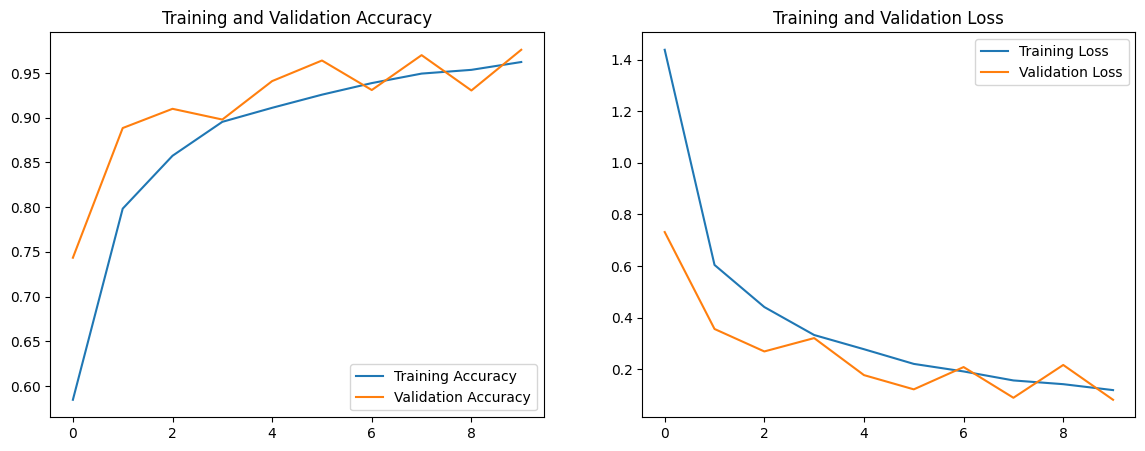

In [11]:
def plot_training(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
    plt.title("Training and Validation Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
    plt.title("Training and Validation Loss")
    plt.show()

plot_training(history)


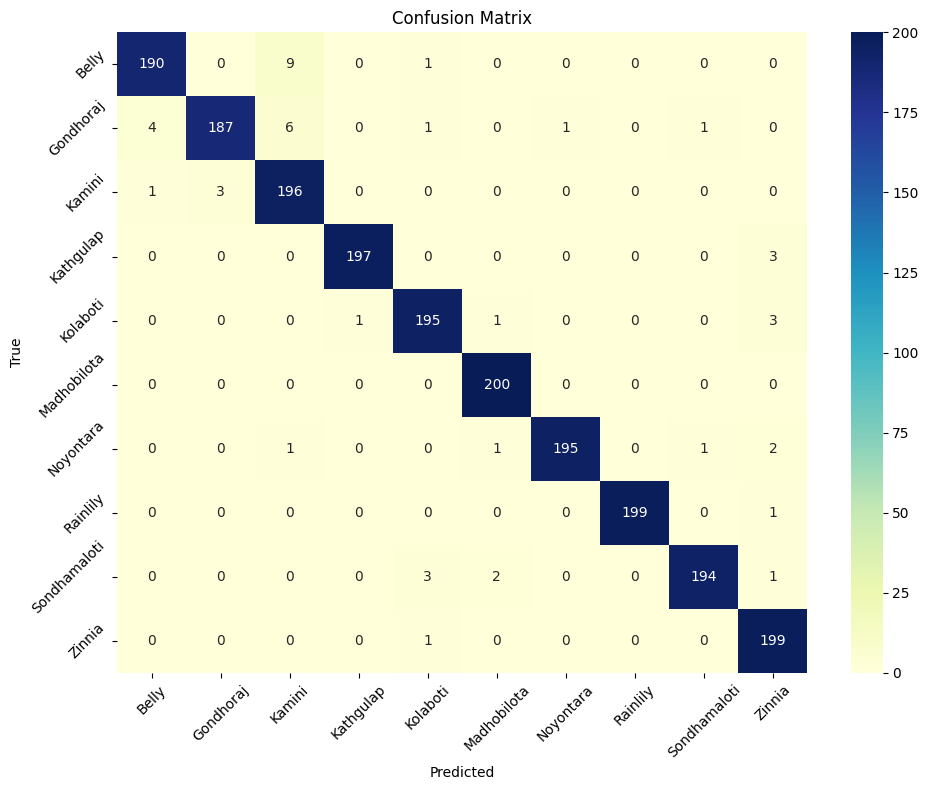


Classification Report:

              precision    recall  f1-score   support

       Belly       0.97      0.95      0.96       200
   Gondhoraj       0.98      0.94      0.96       200
      Kamini       0.92      0.98      0.95       200
   Kathgulap       0.99      0.98      0.99       200
    Kolaboti       0.97      0.97      0.97       200
 Madhobilota       0.98      1.00      0.99       200
   Noyontara       0.99      0.97      0.98       200
    Rainlily       1.00      0.99      1.00       200
Sondhamaloti       0.99      0.97      0.98       200
      Zinnia       0.95      0.99      0.97       200

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Reset the generator to start from the beginning
valid_gen.reset()

# Get predictions
y_true = []
y_pred = []

for i in range(len(valid_gen)):
    images, labels = valid_gen[i]
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="YlGnBu")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


In [13]:
# Save as HDF5 file (single file)
model.save("cswin_flower_model.h5")


In [14]:
from IPython.display import FileLink

FileLink(r'cswin_flower_model.h5')  # Creates a clickable link


/kaggle/working/cswin_flower_model.h5